In [1]:
import skimage.io as io
import numpy as np
from src.functions.image_utils import gaussian_focus_stacker, LoG_focus_stacker
from src.functions.utilities import path_leaf
import os
import glob2 as glob
from skimage.transform import resize
from matplotlib import pyplot as plt
import torch

In [32]:
# set path to image files
experiment_date = "20230613"
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/"
# root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data"
model_name = "mask_v0_0100"
yolk_model_name = "yolk_v1_0050"
stacked_image_path = os.path.join(root, "keyence_stitched_z", experiment_date, "")
seg_image_path = os.path.join(root, "segmentation", model_name + "_predictions", experiment_date, "")
yolk_seg_image_path = os.path.join(root, "segmentation", yolk_model_name + "_predictions", experiment_date, "")

# get list of image stacks
image_list = sorted(glob.glob(stacked_image_path + "*.tif"))

### Load a sample image stack

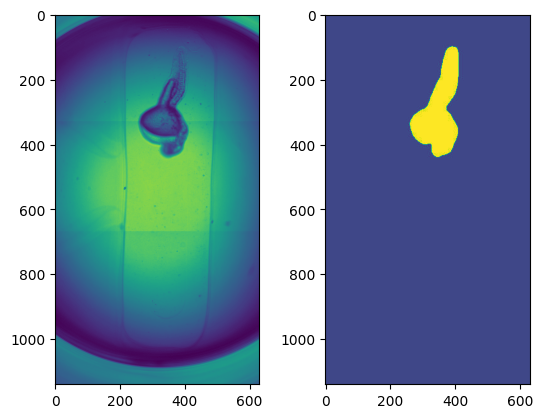

In [40]:
from skimage.transform import resize 

im_ind = 100
im_path = image_list[im_ind]
im_name = path_leaf(im_path)

# load stack
im_stack = io.imread(im_path)

# load mask
mask_path = seg_image_path + im_name[:9] + "_stitch.jpg"
im_mask = io.imread(mask_path)
im_mask = resize(im_mask, im_stack.shape[1:], preserve_range=True, order=0)
im_mask = im_mask - np.min(im_mask)
im_mask = im_mask / np.max(im_mask)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im_stack[15, :, :])
axarr[1].imshow(im_mask)
plt.show()                    

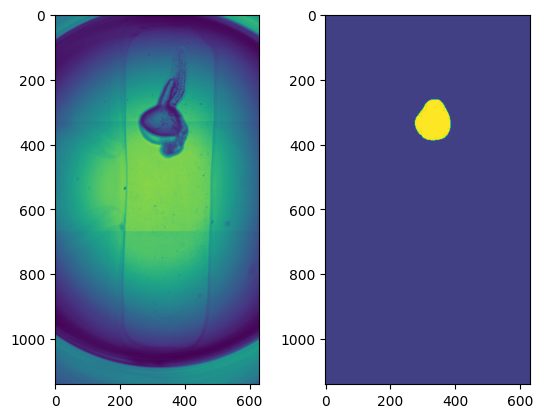

In [41]:
# load yolk mask 
yolk_mask_path = yolk_seg_image_path + im_name[:9] + "_stitch.jpg"
yolk_mask = io.imread(yolk_mask_path)
yolk_mask = resize(yolk_mask, im_stack.shape[1:], preserve_range=True, order=0)
yolk_mask = yolk_mask - np.min(yolk_mask)
yolk_mask = yolk_mask / np.max(yolk_mask)
f, axarr = plt.subplots(1,2)
axarr[0].imshow(im_stack[15, :, :])
axarr[1].imshow(yolk_mask)
plt.show()  

In [52]:
np.min(yolk_mask)

0.0

### Calculate FF using standard method

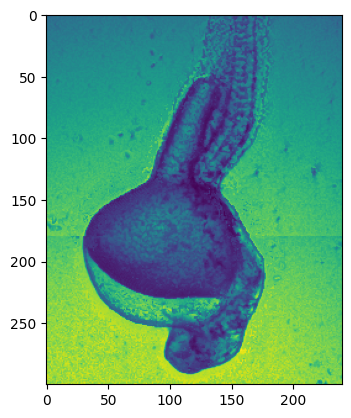

In [46]:
im_FF, abs_laps = LoG_focus_stacker(torch.tensor(im_stack.astype(np.double)), filter_size=3, device="cpu")

y0 = 320-170
y1 = 620-170
x0 = 300-70
x1 = 540-70

plt.imshow(im_FF[y0:y1, x0:x1])
plt.show()

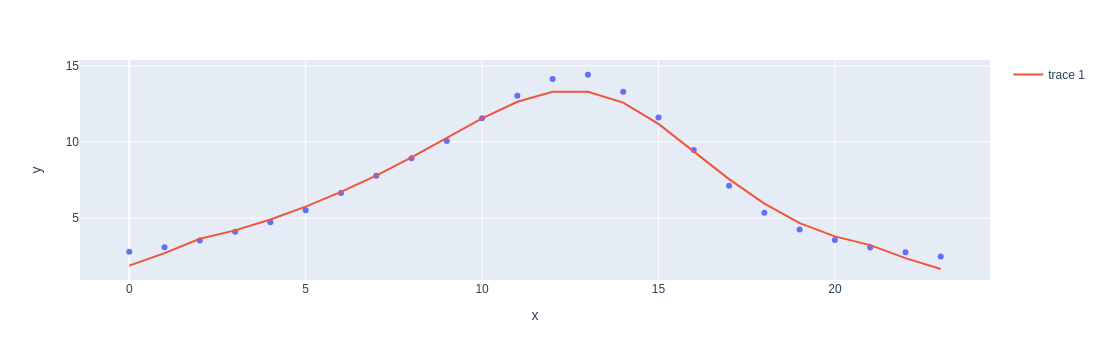

In [63]:
import plotly.express as px
import plotly.graph_objects as go

abs_laps = abs_laps.numpy()
max_i = np.argmax(abs_laps, axis=0)

joint_mask = im_mask.copy()
joint_mask[yolk_mask==1] = 0

mask_laps = []
for i in range(abs_laps.shape[0]):
    mask_laps.append(np.mean(abs_laps[i][joint_mask==1]))

# get moving average
avg_ft = np.ones((5,)) / 5
mask_laps_avg = np.convolve(mask_laps, avg_ft,mode="same")
    
fig = px.scatter(x=range(len(mask_laps)), y=mask_laps)
fig.add_trace(go.Scatter(x=np.arange(len(mask_laps)), y=mask_laps_avg))
fig.show()

In [62]:
np.mean(np.asarray(abs_laps[i][joint_mask==1]))

2.7947040239441305

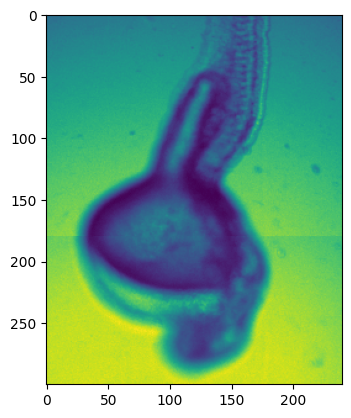

In [72]:
plt.imshow(im_stack[17, y0:y1, x0:x1])
plt.show()

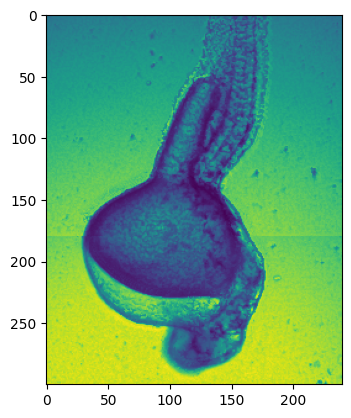

In [83]:
max_i = np.argmax(mask_laps)

im_FF_refined, _ = LoG_focus_stacker(torch.tensor(im_stack[max_i-3:max_i+3].astype(np.double)), filter_size=3, device="cpu")

plt.imshow(im_FF_refined[y0:y1, x0:x1])
plt.show()

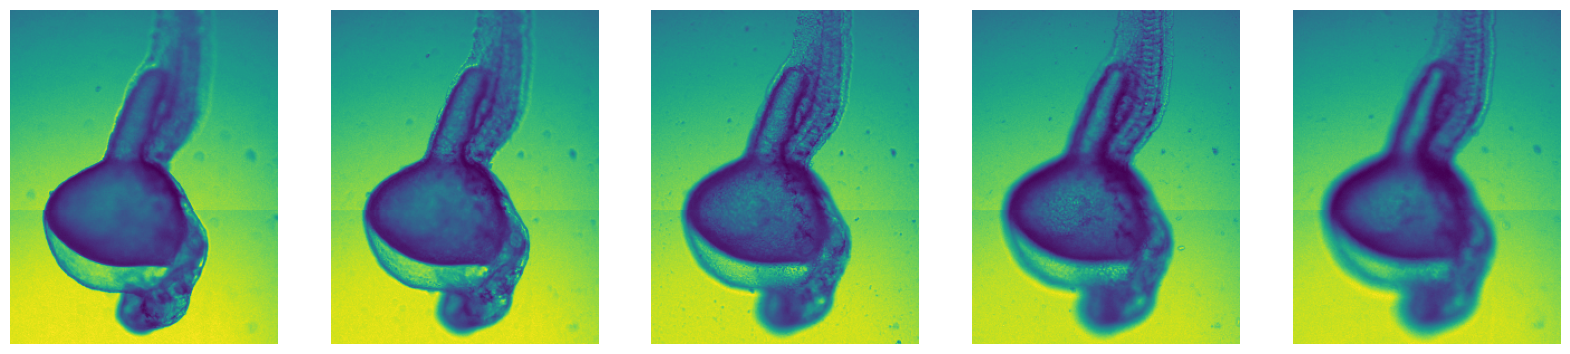

In [75]:
from matplotlib import pyplot

fig = plt.figure(figsize=(20, 30))
ax = fig.subplots(nrows=1, ncols=5)

ax[0].imshow(im_stack[max_i-4, y0:y1, x0:x1])
ax[1].imshow(im_stack[max_i-2, y0:y1, x0:x1])
ax[2].imshow(im_stack[max_i-0, y0:y1, x0:x1])
ax[3].imshow(im_stack[max_i+2, y0:y1, x0:x1])
ax[4].imshow(im_stack[max_i+4, y0:y1, x0:x1])

dummy = [a.axis("off") for a in ax]

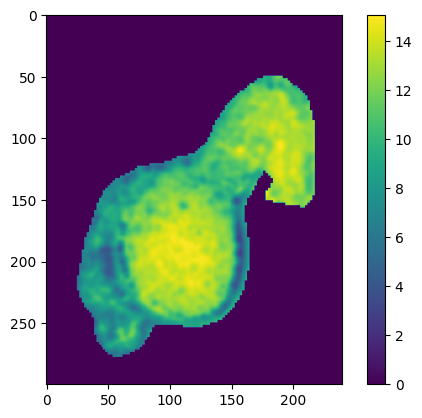

In [58]:
from skimage.filters import gaussian

laps_max = np.multiply(gaussian(np.argmax(abs_laps, axis=0), sigma=2, preserve_range=True), im_mask>0.5)
fig = plt.figure()
im = plt.imshow(laps_max[y0:y1, x0:x1])
fig.colorbar(im)

In [38]:
im_mask

array([[0.18987342, 0.18987342, 0.18987342, ..., 0.18987342, 0.18987342,
        0.18987342],
       [0.18987342, 0.18987342, 0.18987342, ..., 0.18987342, 0.18987342,
        0.18987342],
       [0.18987342, 0.18987342, 0.18987342, ..., 0.18987342, 0.18987342,
        0.18987342],
       ...,
       [0.18987342, 0.18987342, 0.18987342, ..., 0.18987342, 0.18987342,
        0.18987342],
       [0.18987342, 0.18987342, 0.18987342, ..., 0.18987342, 0.18987342,
        0.18987342],
       [0.18987342, 0.18987342, 0.18987342, ..., 0.18987342, 0.18987342,
        0.18987342]])

### What if we used a z stack with half the the z resolution?

In [ ]:
im_stack_ds = im_stack[np.arange(0, im_stack.shape[0], 2), :, :]
im_stack_ds2 = im_stack[np.arange(0, im_stack.shape[0], 4), :, :]
im_stack_ds3 = im_stack[np.arange(0, im_stack.shape[0], 6), :, :]
im_FF_ds, _ = LoG_focus_stacker(torch.tensor(im_stack_ds.astype(np.double)), filter_size=3, device="cpu")
im_FF_ds2, _ = LoG_focus_stacker(torch.tensor(im_stack_ds2.astype(np.double)), filter_size=3, device="cpu")
im_FF_ds3, _ = LoG_focus_stacker(torch.tensor(im_stack_ds3.astype(np.double)), filter_size=3, device="cpu")

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(255-im_FF[0:450, 200:500])
axarr[0,1].imshow(255-im_FF_ds[0:450, 200:500])
axarr[1,0].imshow(255-im_FF_ds2[0:450, 200:500])
axarr[1,1].imshow(255-im_FF_ds3[0:450, 200:500])
f.set_figheight(15)
f.set_figwidth(15)
plt.show()      

To my eye, the 2x reduction in z resolution so 80um has almost no impact on quality. Border artifacts a reduction in image sharpness are evident once we go further.

### What if we just take the most in-focus slice?

In [ ]:
# resize the mask
im_mask_rs = resize(im_mask, im_stack.shape[1:], order=0, preserve_range=True)

# turncate the stack
im_stack_trunc = im_stack[6:-6, :, :] # simulate a narrower stack
im_FF, im_laps = LoG_focus_stacker(torch.tensor(im_stack_trunc.astype(np.double)), filter_size=3, device="cpu")
im_FF_g = gaussian_focus_stacker(torch.tensor(im_stack_trunc.astype(np.double)), filter_size=3, device="cpu")

im_laps = np.asarray(im_laps)

focus_vec = np.empty((im_stack_trunc.shape[0]))
for z in range(im_stack_trunc.shape[0]):
    lap_slice = im_laps[z]
    mean_lap = np.mean(lap_slice[im_mask_rs>0])
    focus_vec[z] = mean_lap

best_z = np.argmax(focus_vec)

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(im_FF[100:450, 200:500])
axarr[1].imshow(im_FF_g[100:450, 200:500])
axarr[2].imshow(im_stack_trunc[best_z, 100:450, 200:500])
axarr[0].title.set_text('FF (truncated stack)')
axarr[1].title.set_text('FF (Gauss)')
axarr[2].title.set_text('focus slice')
f.set_figheight(10)
f.set_figwidth(15)
plt.show()    

In [ ]:
focus_vec

In [ ]:
im_laps